In [1]:
from lib.gnaf_db import GnafDb
from lib import notebook_constants as nc

gnaf = GnafDb.create()
gnaf_2 = GnafDb.create(nc.gnaf_dbconf_2, nc.gnaf_dbname_2)
gnaf.wait_till_running()
gnaf_2.wait_till_running()

g_eng1 = gnaf_2.engine()
g_eng2 = gnaf_2.engine()

In [2]:
import pandas as pd

pd.read_sql("""SELECT gcc_name FROM abs_main_structures.GCCSA""", g_eng1).head()

,gcc_name
0,Greater Sydney
1,Rest of NSW
2,No usual address (NSW)
3,Migratory - Offshore - Shipping (NSW)
4,Greater Melbourne


<Axes: >

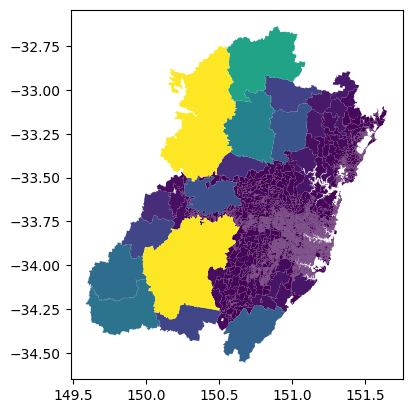

In [3]:
import geopandas as gpd

gpd.read_postgis("""

SELECT DISTINCT sa.area_sqkm, sa.geometry
  FROM abs_main_structures.sa1 sa
  JOIN abs_main_structures.gccsa ag 
    ON ST_Intersects(sa.geometry, ag.geometry)
 WHERE ag.gcc_name = 'Greater Sydney'
 
""", g_eng1, geom_col='geometry').plot(column='area_sqkm')

In [4]:
import pandas as pd

pd.concat([
    pd.read_sql(f"""
        SELECT '{schema}' as schema, '{row['table_name']}' as name, COUNT(*) as count
          FROM {schema}.{row['table_name']}
    """, g_eng1)
    for schema in [
        'abs_main_structures',
        'non_abs_main_structures',
        'nsw_valuer_general',
        'gnaf',
    ]
    for index, row in pd.read_sql(f"""
        SELECT table_name 
          FROM information_schema.tables
         WHERE table_schema = '{schema}'
    """, g_eng1).iterrows()
]).reset_index(drop=True)

,schema,name,count
0,abs_main_structures,state,10
1,abs_main_structures,gccsa,35
2,abs_main_structures,sa4,108
3,abs_main_structures,sa3,359
4,abs_main_structures,sa2,2473
...,...,...,...
61,gnaf,street_locality_alias,39913
62,gnaf,street_locality_alias_type_aut,2
63,gnaf,street_locality_point,712292
64,gnaf,street_suffix_aut,19


,property_description,land_parcel_id,property_name,property_id,zone_code,rank,per_m2,land_value,area,name,unit,house,street,suburb,postcode,geometry
1995,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...",5/SP64838,None,2854446,R1,2.895000e+07,15589.660743,38600000,2476.0,None,None,30-32,WARAYAMA PL,ROZELLE,2039,"POLYGON ((151.16476 -33.86096, 151.16484 -33.8..."
2049,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...",46/SP74637,None,3165500,R4,1.410000e+07,12500.000000,18800000,1504.0,None,None,1,GLADSTONE ST,NEWTOWN,2042,"POLYGON ((151.17562 -33.89799, 151.17616 -33.8..."
586,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...",28/SP4115,STRATA SCHEME,1924117,R1,1.882500e+07,12291.870715,25100000,2042.0,STRATA SCHEME,None,5,GALLIMORE AVE,BALMAIN EAST,2041,"POLYGON ((151.19392 -33.8556, 151.19403 -33.85..."
2208,B/404265,B/404265,None,1936307,R1,3.210002e+06,11280.969953,4280000,379.4,None,None,194,SHORT ST,BIRCHGROVE,2041,"POLYGON ((151.18265 -33.85263, 151.18279 -33.8..."
2121,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...",3/SP3257,YURUGA,1924080,R1,2.265000e+07,11160.384331,30200000,2706.0,YURUGA,None,3,GALLIMORE AVE,BALMAIN EAST,2041,"POLYGON ((151.19506 -33.85604, 151.19467 -33.8..."


<Axes: >

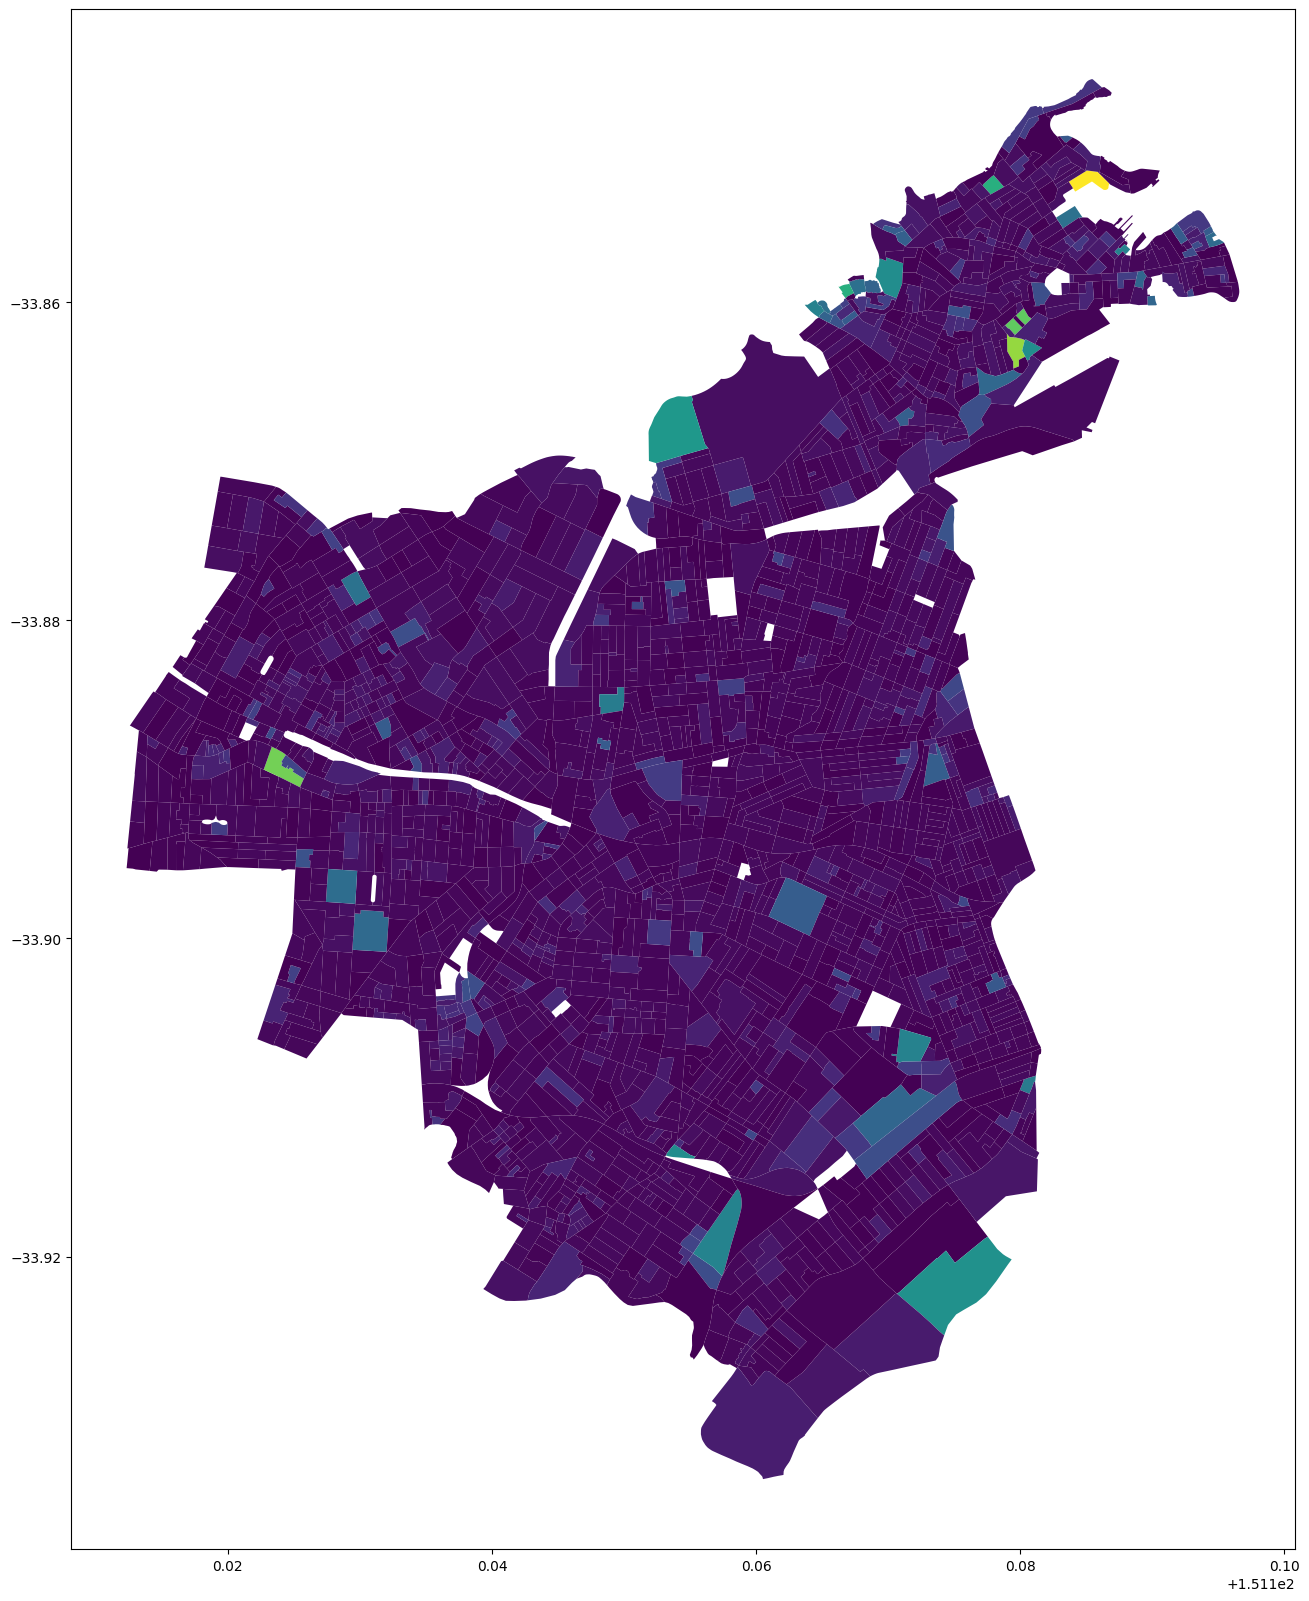

In [111]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import text
from lib.gnaf_db import GnafDb
from lib import notebook_constants as nc

should_be_hectares = (
    # Public schools
    '2109562',
    '3045369',
    
    # Hospitial
    '1915895',

    # Random houses
    '2013895', # 301/807604, 3.507sqm, (a house)
    '2007459', # 286/230712, 8.230sqm, (a house)
    '1976991', # 3/34169, 22.3sqm, (a house)
    '1984039', # 4/6700, 46.8sqm, (a house)
    
    # Unsure what happened here
    '4062073',
    '3803977',
    '1935693',
    '1986173', # 1063/752015, 2.116sqm, (a field)
    '1390065', # 130/1007385, 15.3sqm
)

bh_df = gpd.read_postgis(text("""
  WITH lga_mb AS (
       SELECT asbmb.*
         FROM abs_main_structures.Meshblock asbmb
         LEFT JOIN non_abs_main_structures.lga_2024 lga ON ST_Intersects(asbmb.geometry, lga.geometry)
        WHERE lga.lga_name IN :lga_names
          AND (ST_Area(ST_Intersection(asbmb.geometry, lga.geometry)) / ST_Area(asbmb.geometry)) > 0.5
  ), 
  
  p_in_lga AS (
       SELECT DISTINCT ON (p.property_id, lp.land_parcel_id) p.*, asbmb.*, lp.land_parcel_id
         FROM nsw_valuer_general.property p
         LEFT JOIN nsw_valuer_general.land_parcel_link lp ON p.property_id = lp.property_id
         LEFT JOIN gnaf.ADDRESS_DETAIL ad ON lp.land_parcel_id = ad.legal_parcel_id
         LEFT JOIN gnaf.ADDRESS_MESH_BLOCK_2021 amb2021 ON ad.address_detail_pid = amb2021.address_detail_pid
         LEFT JOIN gnaf.MB_2021 mb2021 ON amb2021.mb_2021_pid = mb2021.mb_2021_pid
        INNER JOIN lga_mb asbmb ON asbmb.mb_code = mb2021.mb_2021_code
        ORDER BY p.property_id, lp.land_parcel_id
  ),
  
  p_square_area_value AS (
       SELECT DISTINCT ON (p.property_id, p.land_parcel_id)
              p.property_id,
              p.land_parcel_id,
              p.mb_code,
              v.land_value,
              CASE
                WHEN p.area IS NULL THEN 1
                ELSE v.land_value
              END / CASE
                WHEN p.property_id IN :should_be_hectares THEN p.area * 10000
                WHEN p.area IS NULL THEN 1
                WHEN p.area < 10 THEN 10
                -- WHEN p.area < 50 THEN 50.0
                -- WHEN p.area < 100 THEN 100.0
                ELSE p.area
              END as per_m2
         FROM p_in_lga p
         LEFT JOIN (
           SELECT DISTINCT ON (property_id) * FROM nsw_valuer_general.valuations
            ORDER BY property_id, base_date DESC) v 
           ON p.property_id = v.property_id
        ORDER BY p.property_id, p.land_parcel_id
  ),
  
  p_square_area_p95 AS (
      SELECT p.mb_code, PERCENTILE_CONT(:percentile) WITHIN GROUP (ORDER BY per_m2) AS per_m2_p95
        FROM p_square_area_value p GROUP BY p.mb_code
  )
  
    SELECT DISTINCT ON (mb.mb_code) 
           pd.property_description,
           pv.land_parcel_id,
           p.property_name,
           p.property_id, 
           p.zone_code,
           log(pv.land_value) * (1 - :log_scaling) + (pv.land_value * :log_scaling) as rank,
           pv.per_m2 as per_m2,
           pv.land_value,
           p.area,
           p.property_name as name,
           p.unit_number as unit,
           p.house_number as house,
           st.street_name as street,
           su.suburb_name as suburb,
           p.postcode,
           mb.geometry
      FROM nsw_valuer_general.property p
      LEFT JOIN nsw_valuer_general.property_description pd ON pd.property_id = p.property_id
     RIGHT JOIN p_square_area_value pv ON pv.property_id = p.property_id
     INNER JOIN p_square_area_p95 p95 ON p95.mb_code = pv.mb_code
     INNER JOIN lga_mb mb ON mb.mb_code = pv.mb_code
      LEFT JOIN nsw_valuer_general.street st ON p.street_id = st.street_id
      LEFT JOIN nsw_valuer_general.suburb su ON p.suburb_id = su.suburb_id
     WHERE pv.per_m2 IS NOT NULL
     ORDER BY mb.mb_code, pv.per_m2 -- , (p95.per_m2_p95 - pv.per_m2)
"""), g_eng1, params={
    'should_be_hectares': should_be_hectares,
    'lga_names': (
        # 'Sydney',
        'Inner West',
        # 'Canada Bay',
        # 'Burwood',
        # 'Strathfield',
        # 'Randwick',
        # 'Woollahra',
        # 'Waverley',
        # 'Bayside (NSW)',
        # 'Georges River',
        # 'Sutherland',
        # 'Canterbury-Bankstown',
        # 'Parramatta',
        # 'Cumberland',
        # 'Ryde',
        # 'Lane Cove',
        # 'Hunters Hill',
        # 'Willoughby',
        # 'Mosman',
        # 'North Sydney',
        # 'Ku-ring-gai',
        # 'Northern Beaches',
        # 'Hornsby',
        # 'The Hills', 
        # 'Blacktown',
        # 'Liverpool',
        # 'Penrith', 
        # 'Campbelltown (NSW)',
        # 'Camden',
    ),
    'percentile': 0.75,
    'log_scaling': 0.75,
}, geom_col='geometry')


# 'Sydney', 'Inner West', 'Canada Bay',
# 'Burwood', 'Strathfield', 'Randwick',
# 'Woollahra', 'Waverley', 'Bayside (NSW)',
# 'Georges River', 'Canterbury-Bankstown',
# 'Parramatta',  'Cumberland', 'Ryde',
# 'Lane Cove', 'Hunters Hill', 'Willoughby',
# 'Mosman', 'North Sydney', 'Ku-ring-gai', 'Fairfield', 
# 'Northern Beaches', 'The Hills', 'Hornsby', 
# 'Blacktown', 'Liverpool', 'Penrith', 
# 'Sutherland', 'Campbelltown (NSW)', 'Camden',

display(bh_df.sort_values(by='per_m2', ascending=False).head())

bh_df.plot(
    column='rank',
    figsize=(20, 20),
)


<Axes: >

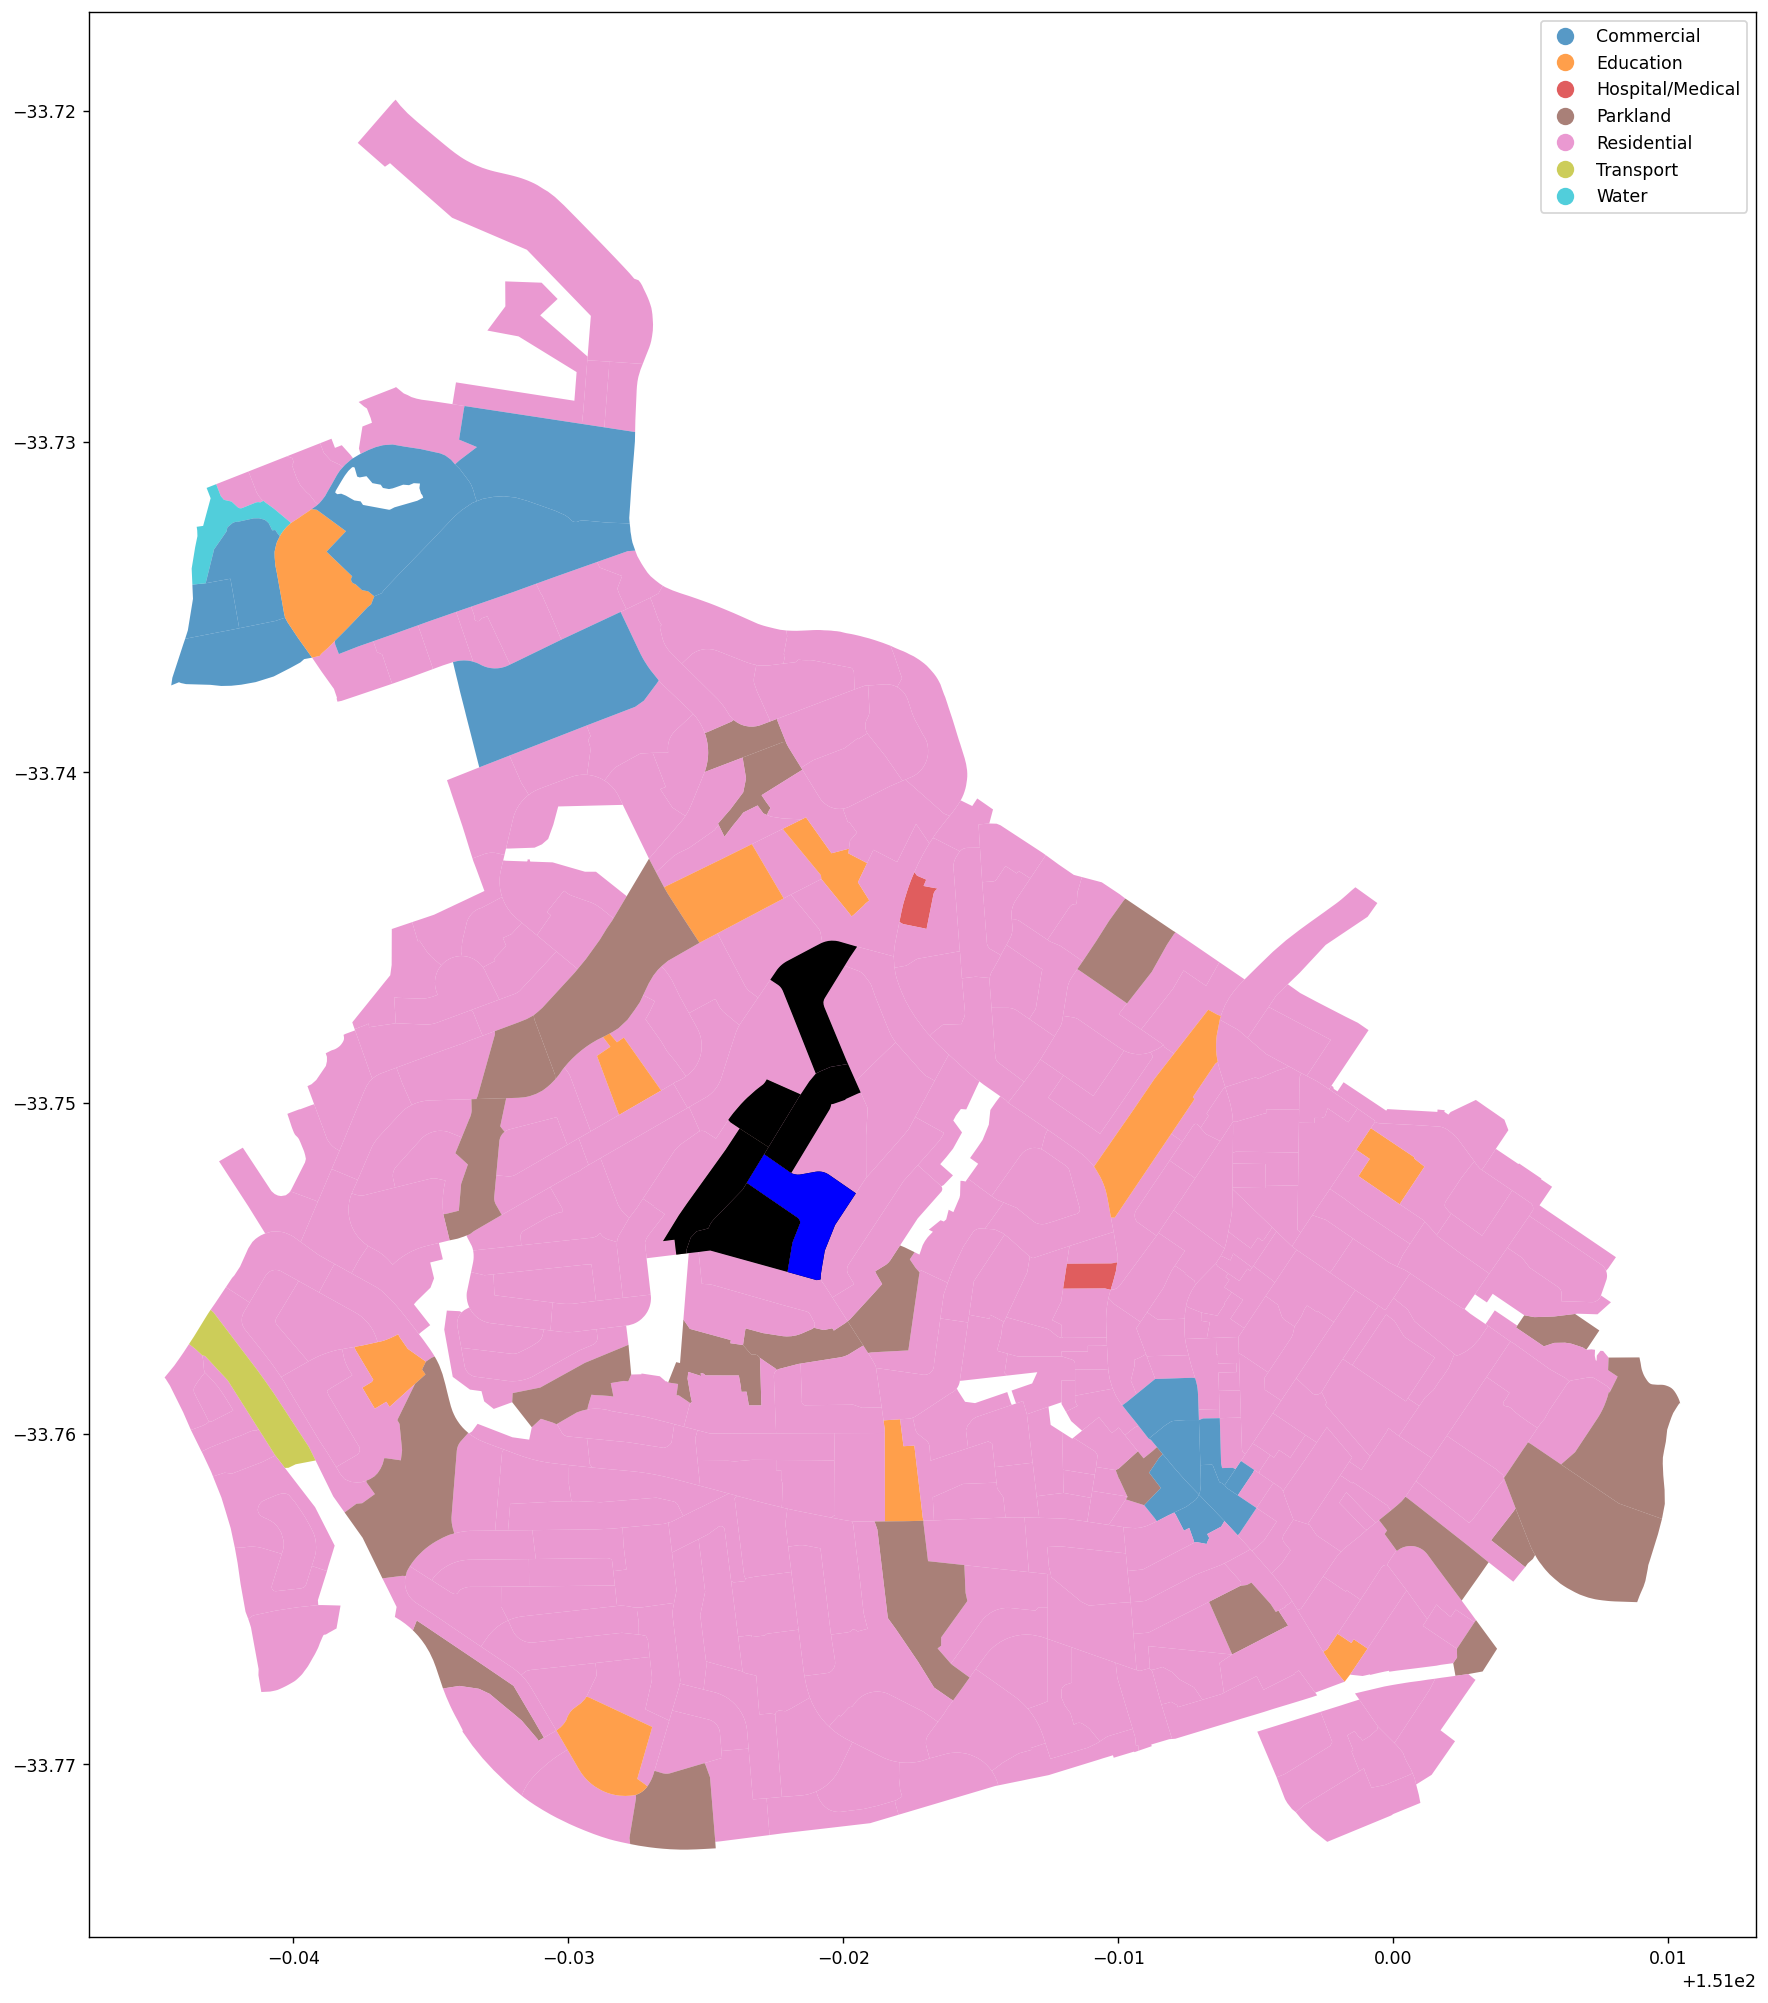

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 20), dpi=125, facecolor='white')

gpd.read_postgis("""
SELECT DISTINCT asbmb.area_sqkm, asbmb.geometry, asbmb.mb_cat
FROM gnaf.LOCALITY l
JOIN gnaf.ADDRESS_DETAIL ad
  ON ad.locality_pid = l.locality_pid
JOIN gnaf.STREET_LOCALITY sl 
  ON ad.street_locality_pid = sl.street_locality_pid
JOIN gnaf.ADDRESS_MESH_BLOCK_2021 amb2021
  ON ad.address_detail_pid = amb2021.address_detail_pid
JOIN gnaf.MB_2021 mb2021
  ON amb2021.mb_2021_pid = mb2021.mb_2021_pid
JOIN abs_main_structures.Meshblock asbmb
  ON asbmb.mb_code = mb2021.mb_2021_code
JOIN gnaf.STATE s
  ON l.state_pid = s.state_pid
WHERE 
    s.state_abbreviation = 'NSW' AND
    l.locality_name IN %(locality_names)s
""", g_eng1, params={
    'locality_names': ('BAULKHAM HILLS',)
}, geom_col='geometry').plot(
    ax=ax,
    column='mb_cat',
    legend=True,
    figsize=(10, 150),
    alpha=0.75
)



gpd.read_postgis("""
SELECT DISTINCT asbmb.area_sqkm, asbmb.geometry, asbmb.mb_cat
FROM gnaf.LOCALITY l
JOIN gnaf.ADDRESS_DETAIL ad
  ON ad.locality_pid = l.locality_pid
JOIN gnaf.STREET_LOCALITY sl 
  ON ad.street_locality_pid = sl.street_locality_pid
JOIN gnaf.ADDRESS_MESH_BLOCK_2021 amb2021
  ON ad.address_detail_pid = amb2021.address_detail_pid
JOIN gnaf.MB_2021 mb2021
  ON amb2021.mb_2021_pid = mb2021.mb_2021_pid
JOIN abs_main_structures.Meshblock asbmb
  ON asbmb.mb_code = mb2021.mb_2021_code
JOIN gnaf.STATE s
  ON l.state_pid = s.state_pid
WHERE 
    s.state_abbreviation = 'NSW' AND
    sl.street_name IN %(street_names)s AND
    l.locality_name IN %(locality_names)s
""", g_eng1, params={
    'street_names': ('TURON',),
    'locality_names': ('BAULKHAM HILLS',)
}, geom_col='geometry').plot(
    ax=ax,
    color='black',
    legend=True,
    figsize=(10, 150),
)

gpd.read_postgis("""
SELECT DISTINCT asbmb.area_sqkm, asbmb.geometry, asbmb.mb_cat
FROM gnaf.LOCALITY l
JOIN gnaf.ADDRESS_DETAIL ad
  ON ad.locality_pid = l.locality_pid
JOIN gnaf.STREET_LOCALITY sl 
  ON ad.street_locality_pid = sl.street_locality_pid
JOIN gnaf.ADDRESS_MESH_BLOCK_2021 amb2021
  ON ad.address_detail_pid = amb2021.address_detail_pid
JOIN gnaf.MB_2021 mb2021
  ON amb2021.mb_2021_pid = mb2021.mb_2021_pid
JOIN abs_main_structures.Meshblock asbmb
  ON asbmb.mb_code = mb2021.mb_2021_code
JOIN gnaf.STATE s
  ON l.state_pid = s.state_pid
WHERE 
    s.state_abbreviation = 'NSW' AND
    ad.number_first = %(street_number)s AND
    sl.street_name IN %(street_names)s AND
    l.locality_name IN %(locality_names)s
""", g_eng1, params={
    'street_number': 40,
    'street_names': ('TURON',),
    'locality_names': ('BAULKHAM HILLS',)
}, geom_col='geometry').plot(
    ax=ax,
    color='blue',
    legend=True,
    figsize=(10, 150),
)

In [7]:
import pandas as pd

engine = gnaf.engine()

df = pd.read_sql("""
SELECT 
    ad.address_detail_pid,
    ad.building_name,
    ad.lot_number,
    ad.street_locality_pid,
    sl.street_name,
    sl.street_type_code,
    sl.street_suffix_code,
    l.locality_name,
    l.primary_postcode,
    mb.mb_2021_code
FROM 
    gnaf.ADDRESS_DETAIL ad
JOIN 
    gnaf.ADDRESS_MESH_BLOCK_2021 amb ON ad.address_detail_pid = amb.address_detail_pid
JOIN 
    gnaf.MB_2021 mb ON amb.mb_2021_pid = mb.mb_2021_pid
JOIN 
    gnaf.STREET_LOCALITY sl ON ad.street_locality_pid = sl.street_locality_pid
JOIN 
    gnaf.LOCALITY l ON ad.locality_pid = l.locality_pid
WHERE 
    mb.mb_2021_code = '10000010000'
""", engine)
df.head()

,address_detail_pid,building_name,lot_number,street_locality_pid,street_name,street_type_code,street_suffix_code,locality_name,primary_postcode,mb_2021_code
0,GANSW706661784,None,1,NSW2880494,KENILWORTH,STREET,None,EAST ALBURY,None,10000010000
1,GANSW716865013,None,None,NSW2899749,SCHUBACH,STREET,None,EAST ALBURY,None,10000010000
2,GANSW708000580,None,None,NSW2899749,SCHUBACH,STREET,None,EAST ALBURY,None,10000010000
3,GANSW718363124,None,None,NSW2899749,SCHUBACH,STREET,None,EAST ALBURY,None,10000010000
4,GANSW718363125,None,None,NSW2899749,SCHUBACH,STREET,None,EAST ALBURY,None,10000010000


In [8]:
import pandas as pd
lv_data = pd.read_csv('zip-out/lv_20240701/001_LAND_VALUE_DATA_20240701.csv')
display(lv_data.head())

,DISTRICT CODE,DISTRICT NAME,PROPERTY ID,PROPERTY TYPE,PROPERTY NAME,UNIT NUMBER,HOUSE NUMBER,STREET NAME,SUBURB NAME,POSTCODE,...,BASIS 3,BASE DATE 4,LAND VALUE 4,AUTHORITY 4,BASIS 4,BASE DATE 5,LAND VALUE 5,AUTHORITY 5,BASIS 5,Unnamed: 34
0,1,CESSNOCK,3017030,NORMAL,NaN,NaN,25,ECHIDNA CL,BELLBIRD,2325,...,6A(1),01/07/2020,322000.0,14A(1),6A(1),01/07/2019,322000.0,14A(1),6A(1),NaN
1,1,CESSNOCK,3017031,NORMAL,NaN,NaN,27,ECHIDNA CL,BELLBIRD,2325,...,6A(1),01/07/2020,322000.0,14A(1),6A(1),01/07/2019,322000.0,14A(1),6A(1),NaN
2,1,CESSNOCK,3017032,NORMAL,NaN,NaN,41,ECHIDNA CL,BELLBIRD,2325,...,6A(1),01/07/2020,322000.0,14A(1),6A(1),01/07/2019,322000.0,14A(1),6A(1),NaN
3,1,CESSNOCK,3017033,NORMAL,NaN,NaN,43,ECHIDNA CL,BELLBIRD,2325,...,6A(1),01/07/2020,322000.0,14A(1),6A(1),01/07/2019,322000.0,14A(1),6A(1),NaN
4,1,CESSNOCK,3017034,NORMAL,NaN,NaN,45,ECHIDNA CL,BELLBIRD,2325,...,6A(1),01/07/2020,309000.0,14A(1),6A(1),01/07/2019,309000.0,14A(1),6A(1),NaN


In [9]:
import pandas as pd
from fuzzywuzzy import process

lv_data = pd.read_csv('zip-out/lv_20240701/001_LAND_VALUE_DATA_20240701.csv')
lv_data = lv_data.rename(columns={
    'DISTRICT CODE': 'district_code',
    'DISTRICT NAME': 'district_name',
    'PROPERTY ID': 'property_id',
    'PROPERTY TYPE': 'property_type',
    'PROPERTY NAME': 'property_name',
    'UNIT NUMBER': 'unit_number',
    'HOUSE NUMBER': 'house_number',
    'STREET NAME': 'street_name_lv',
    'SUBURB NAME': 'suburb',
    'POSTCODE': 'postcode',
    'PROPERTY DESCRIPTION': 'property_description',
    'ZONE CODE': 'zone_code',
    'AREA': 'area',
    'AREA TYPE': 'area_type',
})

lv_data['postcode'] = [str(n) for n in lv_data['postcode']]

gnaf_names = pd.read_sql("""
SELECT DISTINCT 
    sl.street_locality_pid,
    sl.street_name,
    l.locality_name as suburb,
    ad.postcode

  FROM gnaf.ADDRESS_DETAIL ad
  JOIN gnaf.STREET_LOCALITY sl ON ad.street_locality_pid = sl.street_locality_pid
  JOIN gnaf.locality l ON sl.locality_pid = l.locality_pid
  JOIN gnaf.state s ON l.state_pid = s.state_pid
 
 WHERE l.locality_name IN %(locality_names)s
   AND ad.postcode IN %(post_codes)s
   AND s.state_abbreviation = 'NSW'
""", gnaf.engine(), params={
    'locality_names': tuple(lv_data['suburb'].unique()),
    'post_codes': tuple(lv_data['postcode'].unique()),
})


gnaf_names['postcode'] = [str(n) for n in gnaf_names['postcode']]


lv_data_unique = lv_data[~lv_data['street_name_lv'].isna()]
lv_data_unique = lv_data_unique[['street_name_lv', 'postcode', 'suburb']].drop_duplicates()

def fuzzy_match(row, choices, field):
    matches = process.extract(row[field], choices, limit=1)
    # print(matches, row[field], choices)
    if matches:
        return matches[0][0]
    return None

# Apply fuzzy matching for each unique street name in the land value data
matched_street_names = []
for _, row in lv_data_unique.iterrows():
    subset = gnaf_names[(gnaf_names['postcode'] == row['postcode']) & (gnaf_names['suburb'] == row['suburb'])]
    choices = subset['street_name'].tolist()
    match = fuzzy_match(row, choices, 'street_name_lv')
    matched_street_names.append(match)

lv_data_unique['street_name'] = matched_street_names
lv_data = lv_data.merge(lv_data_unique, how='left', on=['street_name_lv', 'postcode', 'suburb'])

display(lv_data.head())
display(lv_data['area_type'].unique())

unknown_street = lv_data[lv_data['street_name_lv'].isna()]

for i, row in unknown_street.iterrows():
    name = unknown_street.loc[i, 'property_name']
    desc = unknown_street.loc[i, 'property_description']
    print(name, desc)
    
# display(unknown_street[['property_name', 'property_description']].head())


gnaf_props = pd.read_sql("""
SELECT DISTINCT 
    ad.address_detail_pid,
    ad.building_name as property_name,
    sl.street_name,
    l.locality_name as suburb,
    ad.postcode
    -- ,  aas.address_site_name as property_name
  FROM gnaf.ADDRESS_DETAIL ad
  JOIN gnaf.LOCALITY l ON ad.locality_pid = l.locality_pid
  JOIN gnaf.STREET_LOCALITY sl ON ad.street_locality_pid = sl.street_locality_pid
  JOIN gnaf.STATE s ON l.state_pid = s.state_pid
  JOIN gnaf.ADDRESS_SITE aas ON ad.address_site_pid = aas.address_site_pid
 WHERE l.locality_name IN %(locality_names)s
   AND ad.postcode IN %(post_codes)s
   AND s.state_abbreviation = 'NSW'
   AND ad.building_name IS NOT NULL
   -- AND aas.address_site_name IS NOT NULL
   -- AND (ad.building_name IS NOT NULL OR aas.address_site_name IS NOT NULL)
""", gnaf.engine(), params={
    'locality_names': tuple(unknown_street['suburb'].unique()),
    'post_codes': tuple(unknown_street['postcode'].unique()),
})

# for _, row in unknown_street.iterrows():
#     subset = gnaf_props[(gnaf_props['postcode'] == row['postcode']) & (gnaf_props['suburb'] == row['suburb'])]
#     choices = subset['property_name'].tolist()
#     match = fuzzy_match(row, choices, 'property_name')
#     print(row['property_name'], match)

# display(gnaf_properties.head())



,district_code,district_name,property_id,property_type,property_name,unit_number,house_number,street_name_lv,suburb,postcode,...,BASE DATE 4,LAND VALUE 4,AUTHORITY 4,BASIS 4,BASE DATE 5,LAND VALUE 5,AUTHORITY 5,BASIS 5,Unnamed: 34,street_name
0,1,CESSNOCK,3017030,NORMAL,NaN,NaN,25,ECHIDNA CL,BELLBIRD,2325,...,01/07/2020,322000.0,14A(1),6A(1),01/07/2019,322000.0,14A(1),6A(1),NaN,ECHIDNA
1,1,CESSNOCK,3017031,NORMAL,NaN,NaN,27,ECHIDNA CL,BELLBIRD,2325,...,01/07/2020,322000.0,14A(1),6A(1),01/07/2019,322000.0,14A(1),6A(1),NaN,ECHIDNA
2,1,CESSNOCK,3017032,NORMAL,NaN,NaN,41,ECHIDNA CL,BELLBIRD,2325,...,01/07/2020,322000.0,14A(1),6A(1),01/07/2019,322000.0,14A(1),6A(1),NaN,ECHIDNA
3,1,CESSNOCK,3017033,NORMAL,NaN,NaN,43,ECHIDNA CL,BELLBIRD,2325,...,01/07/2020,322000.0,14A(1),6A(1),01/07/2019,322000.0,14A(1),6A(1),NaN,ECHIDNA
4,1,CESSNOCK,3017034,NORMAL,NaN,NaN,45,ECHIDNA CL,BELLBIRD,2325,...,01/07/2020,309000.0,14A(1),6A(1),01/07/2019,309000.0,14A(1),6A(1),NaN,ECHIDNA


array(['M', 'H', nan], dtype=object)

PART TASMAN COLLIERY PT 2/809377 PT 101/1164569 SUBSURFACE AREA = 221.11HA Mining Lease 1555 Mining Lease 1703


In [10]:
import pandas as pd

# Load the land value data
lv_data = pd.read_csv('zip-out/lv_20240701/001_LAND_VALUE_DATA_20240701.csv')
lv_data['POSTCODE'] = lv_data['POSTCODE'].astype(str)
lv_data['PROPERTY ID'] = lv_data['PROPERTY ID'].astype(str)

# Query the GNAF database to get the address details for the property IDs in the land value data
property_ids = tuple(lv_data['PROPERTY ID'].unique())

gnaf_addresses = pd.read_sql("""
SELECT DISTINCT 
    ad.address_detail_pid,
    ad.building_name,
    ad.lot_number,
    ad.flat_type_code,
    ad.flat_number,
    ad.level_type_code,
    ad.level_number,
    ad.number_first,
    ad.number_last,
    sl.street_name,
    l.locality_name AS suburb,
    ad.postcode,
    ad.property_pid,
    ad.gnaf_property_pid
  FROM gnaf.ADDRESS_DETAIL ad
  JOIN gnaf.STREET_LOCALITY sl ON ad.street_locality_pid = sl.street_locality_pid
  JOIN gnaf.locality l ON ad.locality_pid = l.locality_pid
  JOIN gnaf.state s ON l.state_pid = s.state_pid
 WHERE l.locality_name IN %(locality_names)s
   AND ad.postcode IN %(post_codes)s
   AND s.state_abbreviation = 'NSW'
""", gnaf.engine(), params={
    'locality_names': tuple(lv_data['SUBURB NAME'].unique()),
    'post_codes': tuple(lv_data['POSTCODE'].unique()),
})


# Ensure postcodes are treated as strings
gnaf_addresses['postcode'] = gnaf_addresses['postcode'].astype(str)

# Merge the land value data with the GNAF addresses based on property_id
merged_data = pd.merge(lv_data, gnaf_addresses, how='left', left_on='PROPERTY ID', right_on='property_pid')

display(gnaf_addresses.head())
# Display results
print("Merged Data:")
display(merged_data.head())

# Identify rows that failed to match
failed_matches = merged_data[merged_data['street_name'].isnull()]

# Display debug information
print(f"Total rows in land value data: {len(lv_data)}")
print(f"Total matched rows: {len(merged_data) - len(failed_matches)}")
print(f"Total failed matches: {len(failed_matches)}")

# Display failed matches for inspection
print("Failed Matches:")
display(failed_matches)


,address_detail_pid,building_name,lot_number,flat_type_code,flat_number,level_type_code,level_number,number_first,number_last,street_name,suburb,postcode,property_pid,gnaf_property_pid
0,GANSW703875758,None,8,None,NaN,None,NaN,121.0,NaN,CONGEWAI,ABERDARE,2325,None,526
1,GANSW703875759,None,16,None,NaN,None,NaN,122.0,NaN,CONGEWAI,ABERDARE,2325,None,407
2,GANSW703875760,None,9,None,NaN,None,NaN,123.0,NaN,CONGEWAI,ABERDARE,2325,None,527
3,GANSW703875761,None,15,None,NaN,None,NaN,124.0,NaN,CONGEWAI,ABERDARE,2325,None,406
4,GANSW703875762,None,10,None,NaN,None,NaN,125.0,NaN,CONGEWAI,ABERDARE,2325,None,528


Merged Data:


,DISTRICT CODE,DISTRICT NAME,PROPERTY ID,PROPERTY TYPE,PROPERTY NAME,UNIT NUMBER,HOUSE NUMBER,STREET NAME,SUBURB NAME,POSTCODE,...,flat_number,level_type_code,level_number,number_first,number_last,street_name,suburb,postcode,property_pid,gnaf_property_pid
0,1,CESSNOCK,3017030,NORMAL,NaN,NaN,25,ECHIDNA CL,BELLBIRD,2325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,CESSNOCK,3017031,NORMAL,NaN,NaN,27,ECHIDNA CL,BELLBIRD,2325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,CESSNOCK,3017032,NORMAL,NaN,NaN,41,ECHIDNA CL,BELLBIRD,2325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,CESSNOCK,3017033,NORMAL,NaN,NaN,43,ECHIDNA CL,BELLBIRD,2325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,CESSNOCK,3017034,NORMAL,NaN,NaN,45,ECHIDNA CL,BELLBIRD,2325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Total rows in land value data: 29342
Total matched rows: 0
Total failed matches: 29342
Failed Matches:


,DISTRICT CODE,DISTRICT NAME,PROPERTY ID,PROPERTY TYPE,PROPERTY NAME,UNIT NUMBER,HOUSE NUMBER,STREET NAME,SUBURB NAME,POSTCODE,...,flat_number,level_type_code,level_number,number_first,number_last,street_name,suburb,postcode,property_pid,gnaf_property_pid
0,1,CESSNOCK,3017030,NORMAL,NaN,NaN,25,ECHIDNA CL,BELLBIRD,2325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,CESSNOCK,3017031,NORMAL,NaN,NaN,27,ECHIDNA CL,BELLBIRD,2325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,CESSNOCK,3017032,NORMAL,NaN,NaN,41,ECHIDNA CL,BELLBIRD,2325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,CESSNOCK,3017033,NORMAL,NaN,NaN,43,ECHIDNA CL,BELLBIRD,2325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,CESSNOCK,3017034,NORMAL,NaN,NaN,45,ECHIDNA CL,BELLBIRD,2325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29337,1,CESSNOCK,4288380,NORMAL,NaN,NaN,265,BULLS RUN RD,LAGUNA,2325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29338,1,CESSNOCK,4353250,NORMAL,NaN,NaN,118,MAITLAND RD,MULBRING,2323,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29339,1,CESSNOCK,4353252,NORMAL,NaN,NaN,550,MOUNT VIEW RD,MOUNT VIEW,2325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29340,1,CESSNOCK,4353253,NORMAL,NaN,NaN,593,MOUNT VIEW RD,MOUNT VIEW,2325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
lot_numbers = pd.read_sql("""
  SELECT
      ad.address_detail_pid as id,
      ad.legal_parcel_id,
      ad.building_name as name,
      CONCAT(ad.lot_number_prefix, ad.lot_number, ad.lot_number_suffix) as lot,
      CONCAT(ad.flat_number_prefix, ad.flat_number, ad.flat_number_suffix) as unit,
      CONCAT(COALESCE(ad.level_type_code || ' ', ''),
             COALESCE(ad.level_number_prefix || '-', ''),
             ad.level_number,
             COALESCE('-' || ad.level_number_suffix, '')) as level,
      CONCAT(
        ad.number_first_prefix, ad.number_first, ad.number_first_suffix,
        COALESCE('-' || ad.number_last_prefix || ad.number_last || ad.number_last_suffix, '')
      ) as house,
      sl.street_name,
      l.locality_name,
      ad.postcode
    FROM gnaf.ADDRESS_DETAIL ad
    JOIN gnaf.LOCALITY l ON ad.locality_pid = l.locality_pid
    JOIN gnaf.STREET_LOCALITY sl ON ad.street_locality_pid = sl.street_locality_pid
    JOIN gnaf.STATE s ON l.state_pid = s.state_pid
   WHERE s.state_abbreviation = 'NSW'
     AND ad.legal_parcel_id = '1000/1097758'
   ORDER BY street_name, house, level, unit
  OFFSET 0
""", gnaf.engine())
lot_numbers

,id,legal_parcel_id,name,lot,unit,level,house,street_name,locality_name,postcode
0,GANSW712497767,1000/1097758,None,1000,,,198,RIVERSIDE,AIRDS,2560
1,GANSW703886059,1000/1097758,None,81,,,200,RIVERSIDE,AIRDS,2560
2,GANSW703886061,1000/1097758,None,81,,,202,RIVERSIDE,AIRDS,2560
3,GANSW703886063,1000/1097758,None,81,,,204,RIVERSIDE,AIRDS,2560
4,GANSW703886065,1000/1097758,None,81,,,206,RIVERSIDE,AIRDS,2560
5,GANSW703889284,1000/1097758,None,81,,,1,TEMPLETON,AIRDS,2560
6,GANSW706552839,1000/1097758,None,81,,,10,TEMPLETON,AIRDS,2560
7,GANSW703889286,1000/1097758,None,81,,,11,TEMPLETON,AIRDS,2560
8,GANSW703889287,1000/1097758,None,81,,,13,TEMPLETON,AIRDS,2560
9,GANSW703889288,1000/1097758,None,81,,,15,TEMPLETON,AIRDS,2560


In [12]:
from sqlalchemy import text

bh_df = gpd.read_postgis(text("""
    SELECT gcc.*
     FROM abs_main_structures.gccsa gcc
"""), gnaf.engine(), geom_col='geometry')
bh_df.head()

,gcc_code,gcc_name,state_code,geometry
0,1GSYD,Greater Sydney,1,"MULTIPOLYGON (((151.28159 -33.83318, 151.28167..."
1,1RNSW,Rest of NSW,1,"MULTIPOLYGON (((159.0623 -31.50886, 159.06244 ..."
2,19499,No usual address (NSW),1,None
3,19799,Migratory - Offshore - Shipping (NSW),1,None
4,2GMEL,Greater Melbourne,2,"MULTIPOLYGON (((144.88829 -38.5026, 144.88826 ..."


,property_description,property_name,property_id,zone,area,land_value,per_m2,base_date,name,unit,house,street,suburb,postcode,land_parcel_id,geometry
220,"2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15...",QUAY APARTMENTS,2038322,SP5,727.0,113000000,155433.287483,2023-01-07,QUAY APARTMENTS,None,2,PHILLIP ST,SYDNEY,2000,12/SP22014,"POLYGON ((151.21258 -33.86156, 151.21232 -33.8..."
147,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...",REGAL APARTMENTS,2044383,SP5,180.1,23458219,130251.077179,2023-01-07,REGAL APARTMENTS,None,359,SUSSEX ST,SYDNEY,2000,117/SP50845,"POLYGON ((151.20471 -33.87759, 151.2046 -33.87..."
1724,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...",None,4337063,SP5,889.5,87900000,98819.561551,2023-01-07,None,None,160,KING ST,SYDNEY,2000,54/SP102137,"POLYGON ((151.21106 -33.86915, 151.21124 -33.8..."
86,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...",None,3739504,SP5,280.9,27500000,97899.608402,2023-01-07,None,None,141-143,ELIZABETH ST,SYDNEY,2000,6/SP89074,"POLYGON ((151.20947 -33.87072, 151.20918 -33.8..."
115,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...",None,2030633,SP5,184.6,17517571,94894.750813,2023-01-07,None,None,5,HOSKING PL,SYDNEY,2000,14/SP57348,"POLYGON ((151.20867 -33.86566, 151.20857 -33.8..."


,area,area_type,district_code,district_name,property_id,property_type,property_name,unit_number,house_number,street_name,...,land_value_4,authority_4,basis_4,base_date_5,land_value_5,authority_5,basis_5,source_file_position,source_file_name,source_date
0,2.185,M,708,CITY OF SYDNEY,2109562,NORMAL,GARDENERS ROAD PUBLIC SCHOOL,None,827,BOTANY RD,...,9160000,14A(1),14G,2019-01-07,9160000,14A(1),14G,6664,708_LAND_VALUE_DATA_20240801.csv,2024-08-01


<Axes: >

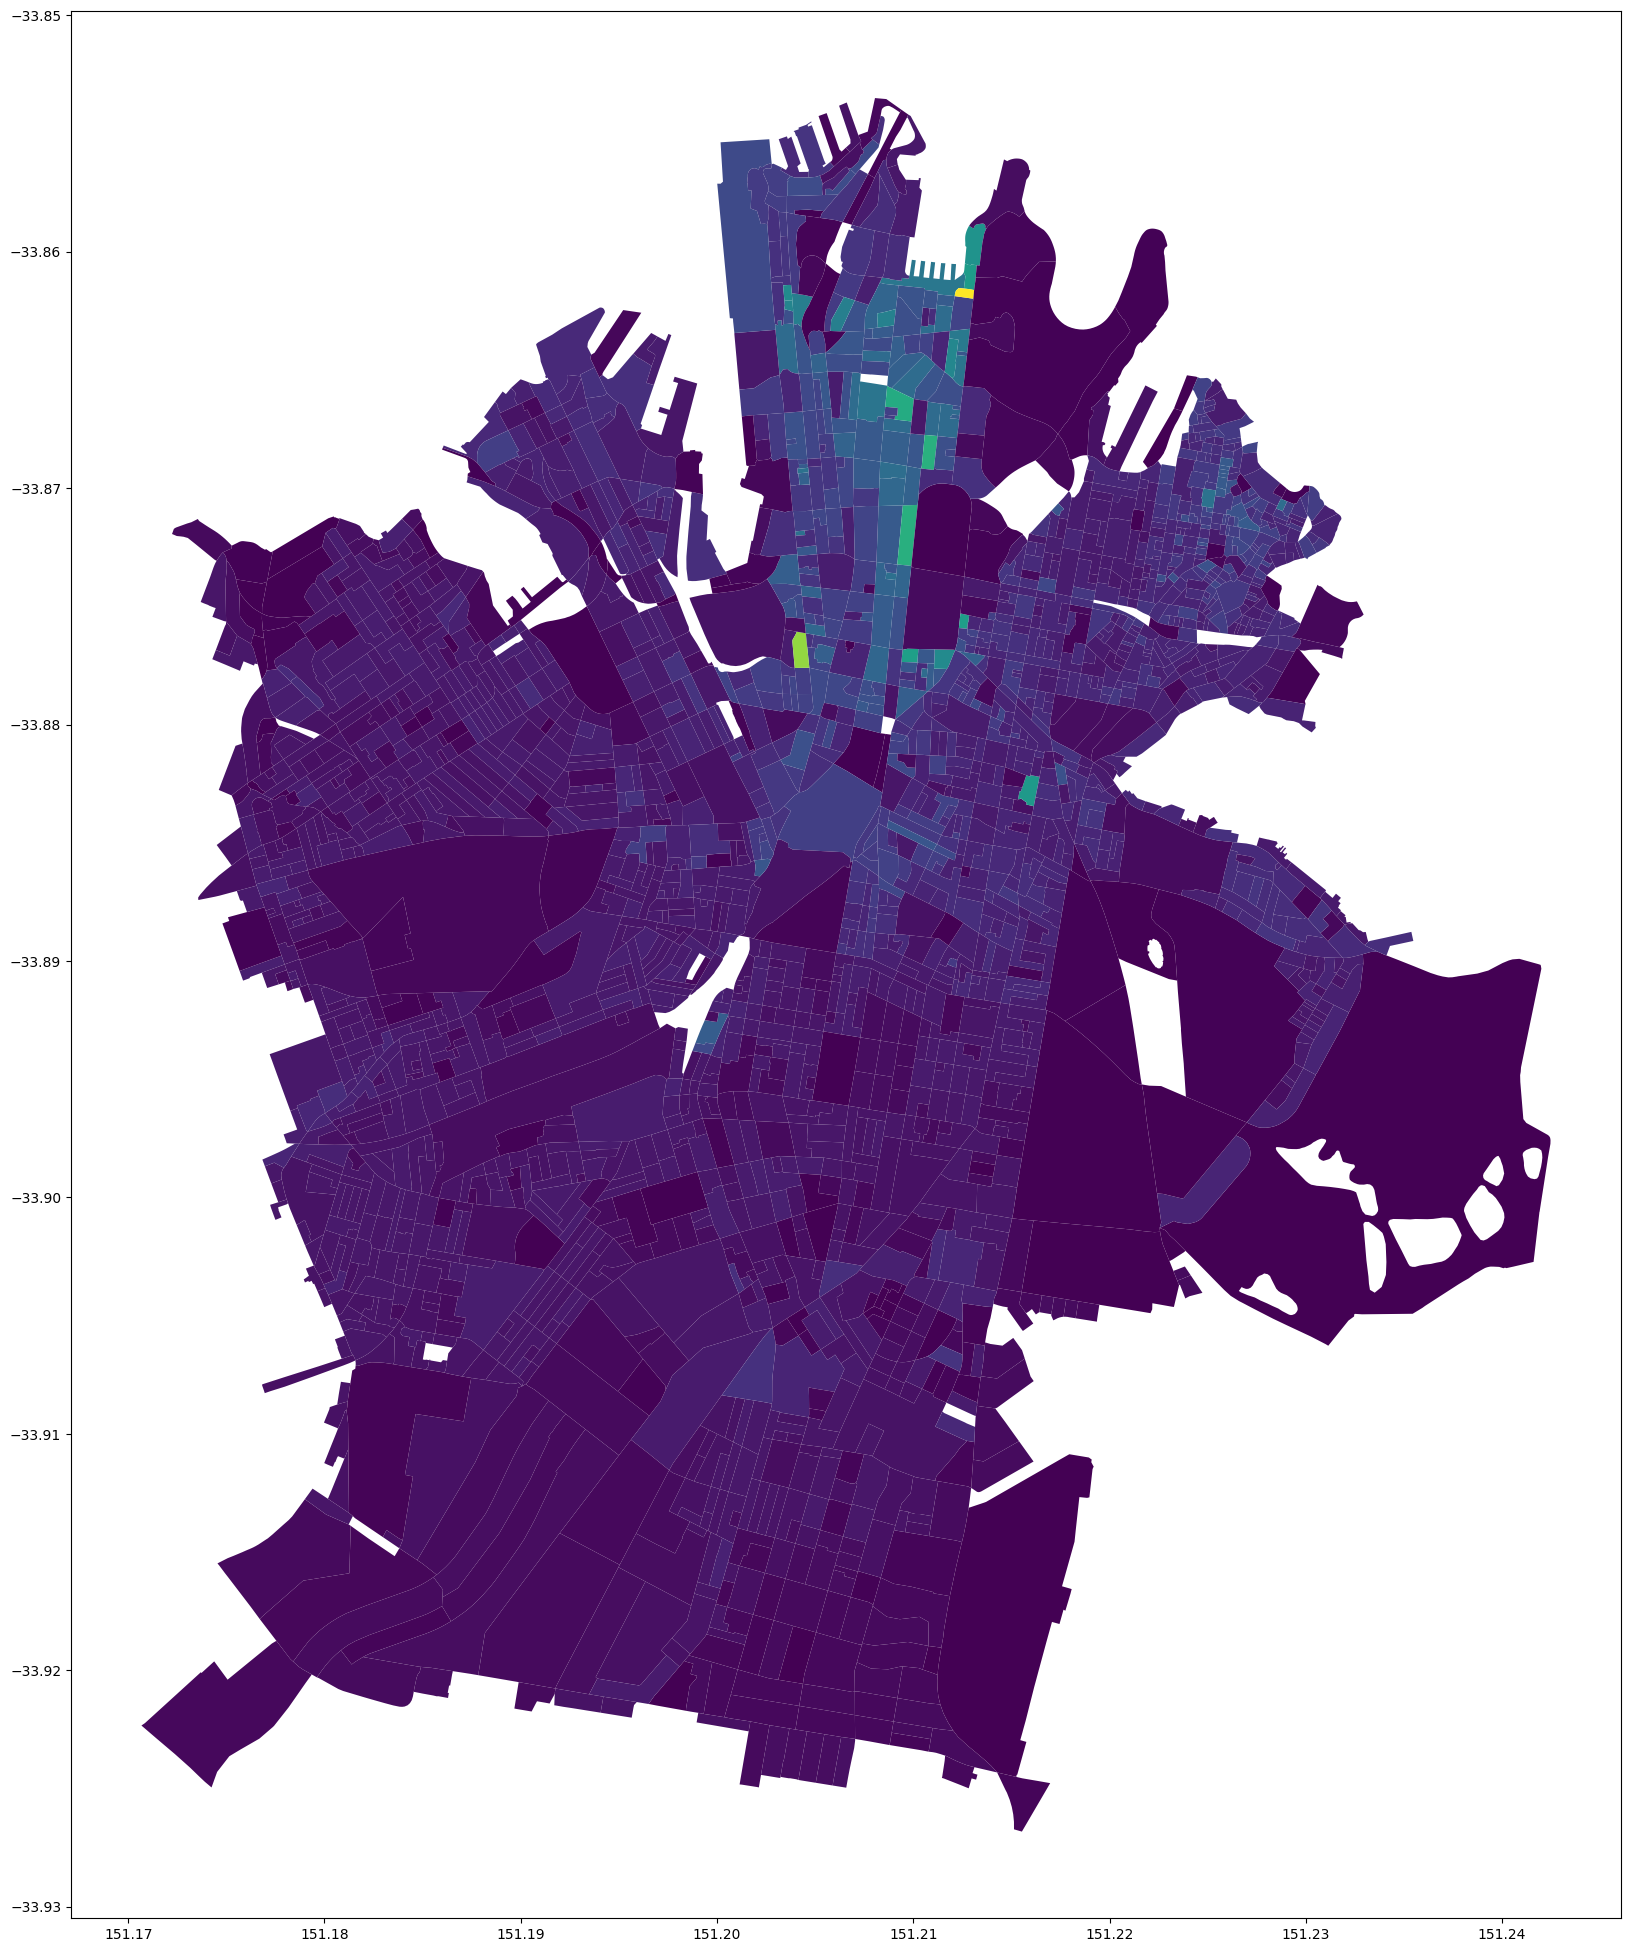

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import text
from lib.gnaf_db import GnafDb
from lib import notebook_constants as nc

df = gpd.read_postgis(text("""
    SELECT DISTINCT ON (asbmb.mb_code)
           pd.property_description,
           p.property_name,
           p.property_id, 
           p.zone_code as zone,
           p.area,
           v.land_value,
           CASE
             WHEN p.area IS NULL THEN 1
             ELSE v.land_value
           END / CASE
             WHEN p.property_id IN :should_be_hectares THEN p.area * 10000
             WHEN p.area IS NULL THEN 1
             WHEN p.area < 10 THEN 10
             WHEN p.area < 50 THEN 50.0
             WHEN p.area < 100 THEN 100.0
             ELSE p.area
           END as per_m2,
           v.base_date,
           p.unit_number as unit,
           p.house_number as house,
           st.street_name as street,
           su.suburb_name as suburb,
           p.postcode,
           lp.land_parcel_id,
           asbmb.geometry
           
      FROM nsw_valuer_general.property p
     
      LEFT JOIN (SELECT DISTINCT ON (property_id) * FROM nsw_valuer_general.valuations
                  ORDER BY property_id, base_date DESC) v ON p.property_id = v.property_id
             
      LEFT JOIN (SELECT * FROM nsw_valuer_general.land_parcel_link
                  ORDER BY property_id, part DESC) lp ON p.property_id = lp.property_id
      
      LEFT JOIN nsw_valuer_general.street st ON p.street_id = st.street_id
      LEFT JOIN nsw_valuer_general.suburb su ON p.suburb_id = su.suburb_id
      LEFT JOIN nsw_valuer_general.property_description pd ON pd.property_id = p.property_id
      LEFT JOIN gnaf.ADDRESS_DETAIL ad ON lp.land_parcel_id = ad.legal_parcel_id
      LEFT JOIN gnaf.ADDRESS_MESH_BLOCK_2021 amb2021 ON ad.address_detail_pid = amb2021.address_detail_pid
      LEFT JOIN gnaf.MB_2021 mb2021 ON amb2021.mb_2021_pid = mb2021.mb_2021_pid
      LEFT JOIN abs_main_structures.Meshblock asbmb ON asbmb.mb_code = mb2021.mb_2021_code
      LEFT JOIN non_abs_main_structures.lga_2024 lga ON ST_Intersects(asbmb.geometry, lga.geometry)
     
     WHERE lga.lga_name = :lga_name
     ORDER BY asbmb.mb_code, per_m2 DESC
"""), g_eng1, params={
    'lga_name': 'Sydney',
    'should_be_hectares': should_be_hectares,
}, geom_col='geometry')

display(df.sort_values(by='per_m2', ascending=False).head())

display(pd.read_sql("""
    SELECT re.area, re.area_type, *
      FROM nsw_valuer_general.raw_entries re
     WHERE re.property_id = '2109562'
""", g_eng1))

df.plot(
    column='per_m2',
    figsize=(20, 300),
)

In [50]:

df = pd.read_sql("""
    SELECT ad.*
      FROM gnaf.ADDRESS_DETAIL ad
      LEFT JOIN gnaf.ADDRESS_SITE ass ON ad.address_site_pid = ass.address_site_pid
      LEFT JOIN gnaf.ADDRESS_DEFAULT_GEOCODE adg ON ad.address_detail_pid = adg.address_detail_pid
      LEFT JOIN gnaf.ADDRESS_SITE_GEOCODE asg ON asg.address_site_pid = ass.address_site_pid
     WHERE ad.legal_parcel_id = '11/813585'
""", g_eng1)

for c in df.columns:
    display(f"{c}: {df.loc[0, c]}")

'address_detail_pid: GANSW710348400'

'date_created: 2009-01-08'

'date_last_modified: 2021-08-05'

'date_retired: None'

'building_name: GARDENERS RD PRIMARY'

'lot_number_prefix: None'

'lot_number: None'

'lot_number_suffix: None'

'flat_type_code: None'

'flat_number_prefix: None'

'flat_number: None'

'flat_number_suffix: None'

'level_type_code: None'

'level_number_prefix: None'

'level_number: None'

'level_number_suffix: None'

'number_first_prefix: None'

'number_first: 827.0'

'number_first_suffix: None'

'number_last_prefix: None'

'number_last: None'

'number_last_suffix: None'

'street_locality_pid: NSW2816825'

'location_description: None'

'locality_pid: loc3bde53666ed1'

'alias_principal: P'

'postcode: 2018'

'private_street: None'

'legal_parcel_id: 11/813585'

'confidence: 1.0'

'address_site_pid: 706066304'

'level_geocoded_code: 7.0'

'property_pid: None'

'gnaf_property_pid: 2109562'

'primary_secondary: None'

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import text
from lib.gnaf_db import GnafDb
from lib import notebook_constants as nc

df = pd.read_sql(text("""
     SELECT DISTINCT ON (property_id) * FROM nsw_valuer_general.valuations
      ORDER BY property_id DESC, base_date DESC
     LIMIT 25
"""), g_eng1, params={
    'lga_name': 'Sydney',
})
df

,property_id,base_date,land_value,authority,basis
0,4563709,2023-01-07,1800000,14A(2),6A(1)
1,4563632,2023-01-07,600000,27,6A(1)
2,4563631,2023-01-07,570000,27,6A(1)
3,4563602,2023-01-07,2745000,14A(2),14I
4,4563597,2023-01-07,150000,19B,6A(1)
5,4563587,2023-01-07,828000,14A(2),6A(1)
6,4563538,2023-01-07,5310000,14A(2),6A(1)
7,4563530,2023-01-07,2300000,14A(2),6A(1)
8,4563514,2023-01-07,625000,27B,6A(1)
9,4563513,2023-01-07,625000,27B,6A(1)


In [21]:

pd.read_sql(text("""
       SELECT lga.lga_name
         FROM non_abs_main_structures.lga_2024 lga
        WHERE lga.lga_name ILIKE :lga_name
"""), g_eng1, params={
    'lga_name': '%Campbell%',
})

,lga_name
0,Campbelltown (NSW)
1,Campbelltown (SA)


In [22]:
import fiona

f = 'zip-out/non_abs_structures_shapefiles/ASGS_Ed3_Non_ABS_Structures_GDA2020_updated_2024.gpkg'
display(fiona.listlayers(f))
df = gpd.read_file(f, layer='DZN_2021_AUST_GDA2020')
display(df.columns)
display(df.head())

['SAL_2021_AUST_GDA2020',
 'ADD_2021_AUST_GDA2020',
 'TR_2021_AUST_GDA2020',
 'SED_2021_AUST_GDA2020',
 'CED_2021_AUST_GDA2020',
 'LGA_2021_AUST_GDA2020',
 'SED_2022_AUST_GDA2020',
 'DZN_2021_AUST_GDA2020',
 'LGA_2022_AUST_GDA2020',
 'POA_2021_AUST_GDA2020',
 'LGA_2023_AUST_GDA2020',
 'SED_2024_AUST_GDA2020',
 'LGA_2024_AUST_GDA2020']

Index(['DZN_CODE_2021', 'SA2_CODE_2021', 'SA2_NAME_2021', 'STATE_CODE_2021',
       'STATE_NAME_2021', 'AUS_CODE_2021', 'AUS_NAME_2021', 'AREA_ALBERS_SQKM',
       'ASGS_LOCI_URI_2021', 'geometry'],
      dtype='object')

,DZN_CODE_2021,SA2_CODE_2021,SA2_NAME_2021,STATE_CODE_2021,STATE_NAME_2021,AUS_CODE_2021,AUS_NAME_2021,AREA_ALBERS_SQKM,ASGS_LOCI_URI_2021,geometry
0,110078098,101021007,Braidwood,1,New South Wales,AUS,Australia,1539.8516,http://linked.data.gov.au/dataset/asgsed3/DZN/...,"MULTIPOLYGON (((149.66351 -35.13827, 149.66066..."
1,110078099,101021007,Braidwood,1,New South Wales,AUS,Australia,234.6163,http://linked.data.gov.au/dataset/asgsed3/DZN/...,"MULTIPOLYGON (((149.72287 -35.41035, 149.72285..."
2,110078100,101021007,Braidwood,1,New South Wales,AUS,Australia,1643.8846,http://linked.data.gov.au/dataset/asgsed3/DZN/...,"MULTIPOLYGON (((149.50348 -35.58416, 149.5036 ..."
3,110088084,101021008,Karabar,1,New South Wales,AUS,Australia,6.9825,http://linked.data.gov.au/dataset/asgsed3/DZN/...,"MULTIPOLYGON (((149.21899 -35.36738, 149.21947..."
4,110090001,101021009,Queanbeyan,1,New South Wales,AUS,Australia,1.9582,http://linked.data.gov.au/dataset/asgsed3/DZN/...,"MULTIPOLYGON (((149.21619 -35.34218, 149.21326..."


In [104]:
import pandas as pd

df = pd.read_sql("""
SELECT DISTINCT *
  FROM abs_main_structures.state s
""", g_eng1)
display(df)

df = pd.read_sql("""
SELECT DISTINCT st.street_name, p.postcode
  FROM nsw_valuer_general.property p
  LEFT JOIN nsw_valuer_general.suburb su ON p.suburb_id = su.suburb_id
  LEFT JOIN nsw_valuer_general.street st ON p.street_id = st.street_id
 WHERE su.suburb_name = 'ADAMINABY'
 LIMIT 5
""", g_eng1)
display(df)

df = pd.read_sql("""
SELECT DISTINCT
    sl.street_locality_pid,
    l.locality_pid,
    sl.street_name || COALESCE(' ' || sta_1.name, '') || COALESCE(' ' || ssa_1.name, '') as street_name,
    asl.street_name || COALESCE(' ' || sta_2.name, '') || COALESCE(' ' || ssa_2.name, '')  as street_name_alias,
    sl.street_class_code,
    sl.date_retired,
    sl.date_created,
    sl.street_suffix_code,
    ad.postcode
  FROM gnaf.ADDRESS_DETAIL ad
  LEFT JOIN gnaf.locality l ON ad.locality_pid = l.locality_pid
  LEFT JOIN gnaf.STREET_LOCALITY sl ON sl.street_locality_pid = ad.street_locality_pid
  LEFT JOIN gnaf.STREET_LOCALITY_ALIAS asl ON sl.street_locality_pid = asl.street_locality_pid
  LEFT JOIN gnaf.STATE s ON l.state_pid = s.state_pid
  LEFT JOIN gnaf.STREET_TYPE_AUT sta_1 ON sta_1.code = sl.street_type_code
  LEFT JOIN gnaf.STREET_TYPE_AUT sta_2 ON sta_2.code = asl.street_type_code
  LEFT JOIN gnaf.STREET_SUFFIX_AUT ssa_1 ON ssa_1.code = sl.street_suffix_code
  LEFT JOIN gnaf.STREET_SUFFIX_AUT ssa_2 ON ssa_2.code = asl.street_suffix_code
 WHERE 
    sl.street_locality_pid IN ('NSW2575294', 'NSW2575296')
""", g_eng1)
display(df)

PendingRollbackError: Can't reconnect until invalid transaction is rolled back.  Please rollback() fully before proceeding (Background on this error at: https://sqlalche.me/e/20/8s2b)

In [105]:
import fiona

# Path to your GeoPackage file
file = 'zip-out/non_abs_structures_shapefiles/ASGS_Ed3_Non_ABS_Structures_GDA2020_updated_2024.gpkg'
layers = ['SAL_2021_AUST_GDA2020', 'ADD_2021_AUST_GDA2020', 'TR_2021_AUST_GDA2020', 'SED_2021_AUST_GDA2020', 'CED_2021_AUST_GDA2020', 'LGA_2021_AUST_GDA2020', 'SED_2022_AUST_GDA2020', 'DZN_2021_AUST_GDA2020', 'LGA_2022_AUST_GDA2020', 'POA_2021_AUST_GDA2020', 'LGA_2023_AUST_GDA2020', 'SED_2024_AUST_GDA2020', 'LGA_2024_AUST_GDA2020']

df = gpd.read_file(file, layer='POA_2021_AUST_GDA2020')
display(df.info())
df['POA_CODE_2021'].str.len().max()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   POA_CODE_2021       2644 non-null   object  
 1   POA_NAME_2021       2644 non-null   object  
 2   AUS_CODE_2021       2644 non-null   object  
 3   AUS_NAME_2021       2644 non-null   object  
 4   AREA_ALBERS_SQKM    2641 non-null   float64 
 5   ASGS_LOCI_URI_2021  2644 non-null   object  
 6   geometry            2641 non-null   geometry
dtypes: float64(1), geometry(1), object(5)
memory usage: 144.7+ KB


None

np.int64(4)

,property_description,land_parcel_id,property_name,property_id,zone_code,rank,per_m2,land_value,area,name,unit,house,street,suburb,postcode,geometry
24332,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...",10/SP72014,None,3087308,R2,1.267500e+07,2522.388060,16900000,6700.00,None,None,33-41,HANKS ST,ASHFIELD,2131,"POLYGON ((151.12501 -33.90282, 151.12504 -33.9..."
24048,11/1007263,11/1007263,None,2779333,R2,1.267500e+07,2289.352479,16900000,7382.00,None,None,91,MILTON ST,ASHFIELD,2131,"POLYGON ((151.1165 -33.89282, 151.11694 -33.89..."
24918,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...",10/SP84873,None,3635683,R2,1.080000e+07,3144.791439,14400000,4579.00,None,None,80,VICTORIA RD,MARRICKVILLE,2204,"POLYGON ((151.16871 -33.90552, 151.16873 -33.9..."
24875,2/1105116,2/1105116,None,3586848,R2,1.027500e+07,2920.486037,13700000,4691.00,None,None,43,QUEEN ST,ASHFIELD,2131,"POLYGON ((151.12521 -33.8944, 151.12532 -33.89..."
25049,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...",10/SP85723,None,3739101,R2,9.825002e+06,2536.793184,13100000,5164.00,None,None,15-25,EDGAR ST,TEMPE,2044,"POLYGON ((151.15941 -33.92024, 151.15918 -33.9..."
6674,"4, 5, 8, 9, 10, 11, 12, 13, 14/10457 2/812589",9/10457,None,1307494,R2,9.675002e+06,1925.281181,12900000,6700.32,None,None,5-25,WATSON AVE,CROYDON PARK,2133,"POLYGON ((151.11663 -33.89572, 151.1166 -33.89..."
25790,20/1247791,20/1247791,None,4234968,R2,9.450002e+06,2709.677419,12600000,4650.00,None,None,222,ALT ST,HABERFIELD,2045,"POLYGON ((151.13634 -33.87409, 151.13617 -33.8..."
20978,"1/105806 1/121240 A, B/308880",A/308880,None,1966475,R2,8.925002e+06,3446.278598,11900000,3453.00,None,None,58-76,STANMORE RD,STANMORE,2048,"POLYGON ((151.16862 -33.89915, 151.16888 -33.8..."
4092,A/416751 3/977800,A/416751,None,1301799,R2,8.700002e+06,2242.846094,11600000,5172.00,None,None,18,LUCY ST,ASHFIELD,2131,"POLYGON ((151.1225 -33.87837, 151.12256 -33.87..."
24859,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...",10/SP85250,None,3574610,R2,7.500002e+06,3161.555485,10000000,3163.00,None,None,27-31,ST PETERS ST,ST PETERS,2044,"POLYGON ((151.17504 -33.91251, 151.17508 -33.9..."


<Axes: >

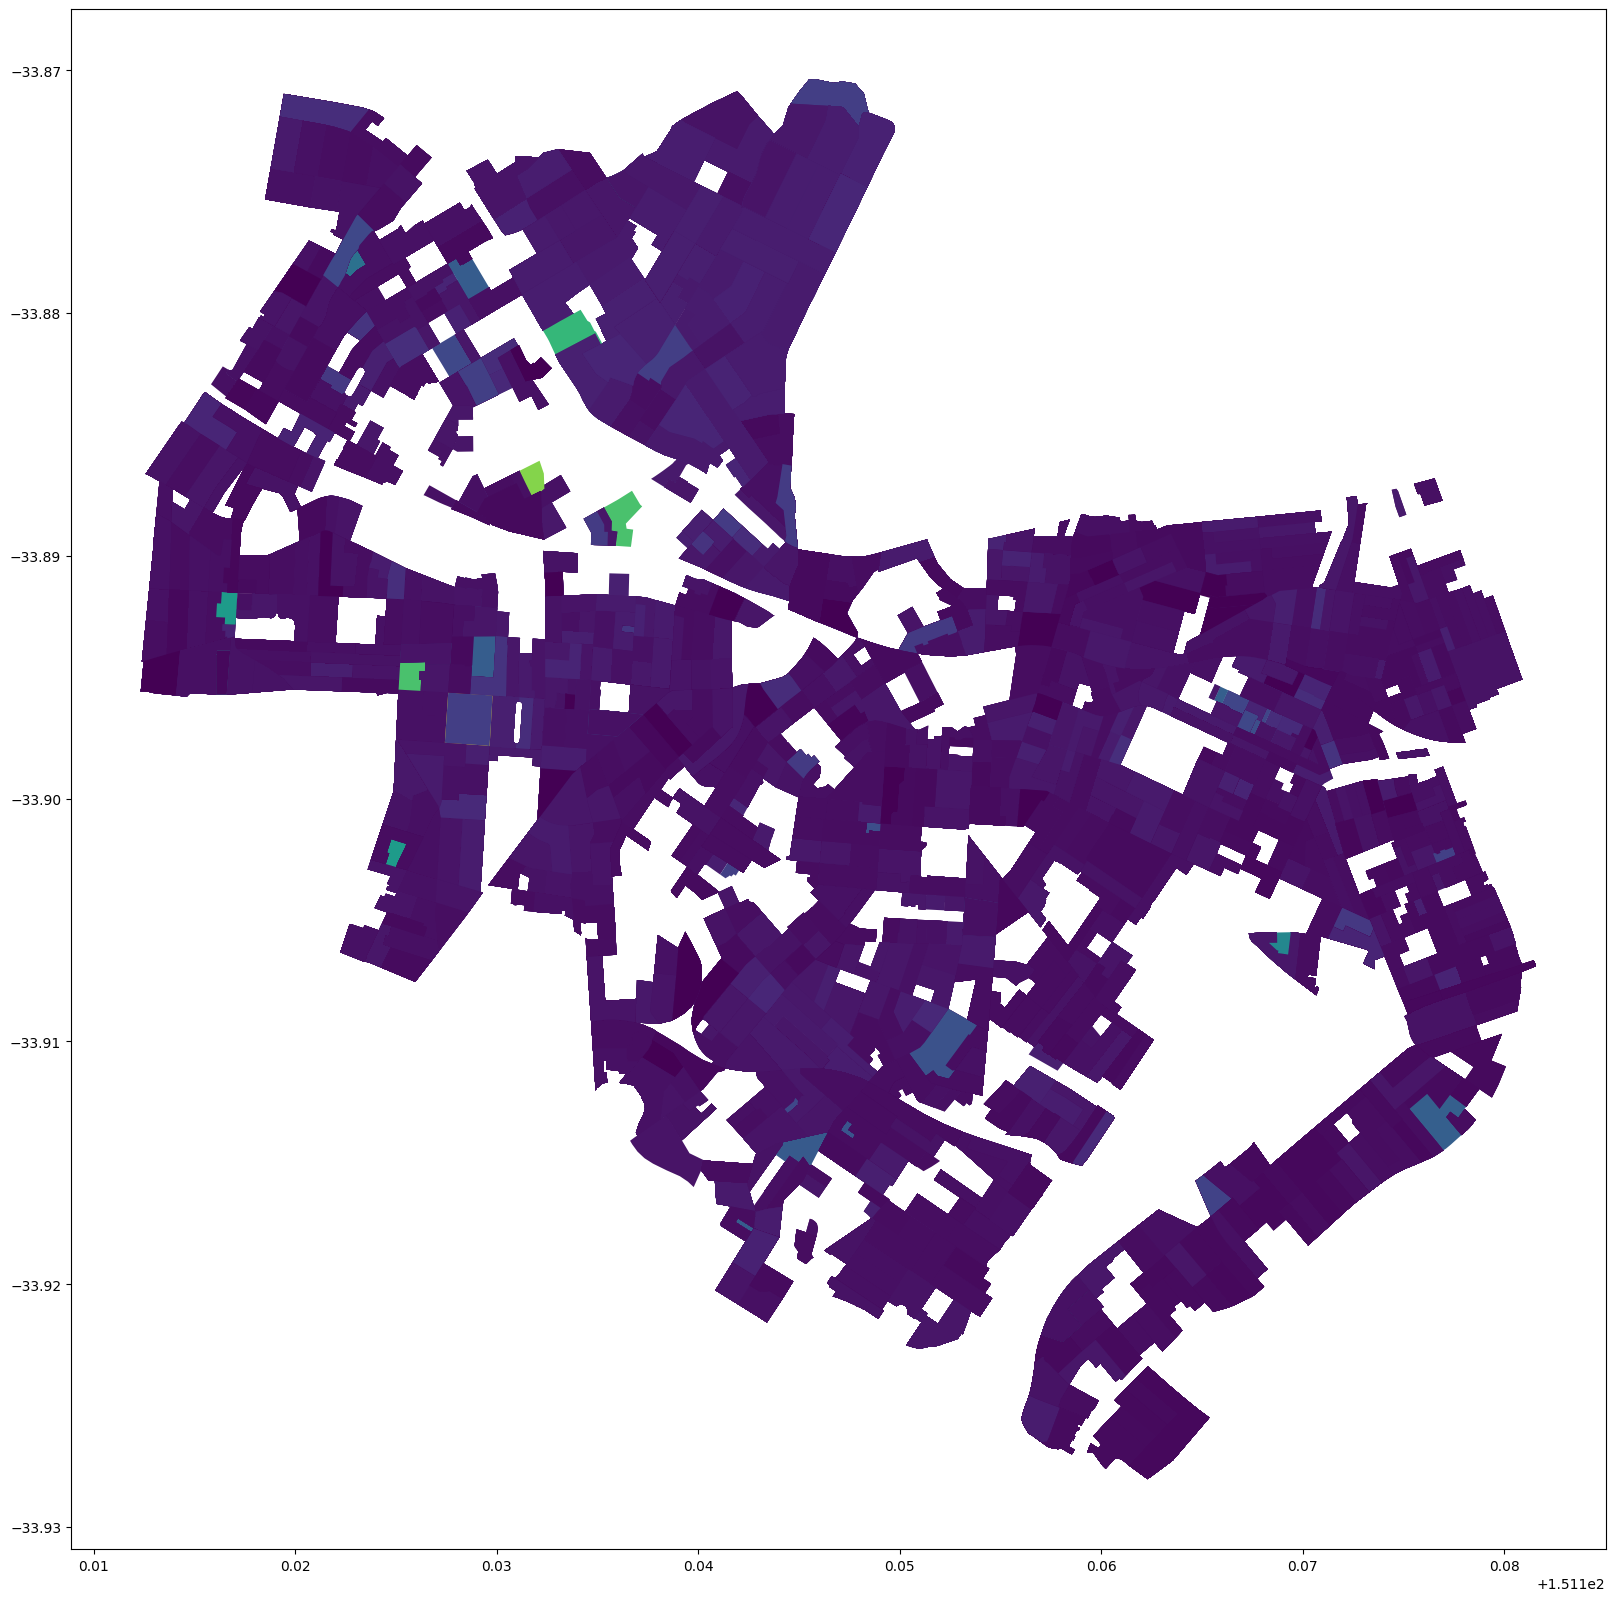

In [110]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import text
from lib.gnaf_db import GnafDb
from lib import notebook_constants as nc

should_be_hectares = (
    # Public schools
    '2109562',
    '3045369',
    
    # Hospitial
    '1915895',

    # Random houses
    '2013895', # 301/807604, 3.507sqm, (a house)
    '2007459', # 286/230712, 8.230sqm, (a house)
    '1976991', # 3/34169, 22.3sqm, (a house)
    '1984039', # 4/6700, 46.8sqm, (a house)
    
    # Unsure what happened here
    '4062073',
    '3803977',
    '1935693',
    '1986173', # 1063/752015, 2.116sqm, (a field)
    '1390065', # 130/1007385, 15.3sqm
)

bh_df = gpd.read_postgis(text("""
  WITH lga_mb AS (
       SELECT asbmb.*
         FROM abs_main_structures.Meshblock asbmb
         LEFT JOIN non_abs_main_structures.lga_2024 lga ON ST_Intersects(asbmb.geometry, lga.geometry)
        WHERE lga.lga_name IN :lga_names
          AND (ST_Area(ST_Intersection(asbmb.geometry, lga.geometry)) / ST_Area(asbmb.geometry)) > 0.5
  ), 
  
  p_in_lga AS (
       SELECT DISTINCT ON (p.property_id, lp.land_parcel_id) p.*, asbmb.*, lp.land_parcel_id
         FROM nsw_valuer_general.property p
         LEFT JOIN nsw_valuer_general.land_parcel_link lp ON p.property_id = lp.property_id
         LEFT JOIN gnaf.ADDRESS_DETAIL ad ON lp.land_parcel_id = ad.legal_parcel_id
         LEFT JOIN gnaf.ADDRESS_MESH_BLOCK_2021 amb2021 ON ad.address_detail_pid = amb2021.address_detail_pid
         LEFT JOIN gnaf.MB_2021 mb2021 ON amb2021.mb_2021_pid = mb2021.mb_2021_pid
        INNER JOIN lga_mb asbmb ON asbmb.mb_code = mb2021.mb_2021_code
        ORDER BY p.property_id, lp.land_parcel_id
  ),
  
  p_square_area_value AS (
       SELECT DISTINCT ON (p.property_id, p.land_parcel_id)
              p.property_id,
              p.land_parcel_id,
              p.mb_code,
              v.land_value,
              CASE
                WHEN p.area IS NULL THEN 1
                ELSE v.land_value
              END / CASE
                WHEN p.property_id IN :should_be_hectares THEN p.area * 10000
                WHEN p.area IS NULL THEN 1
                WHEN p.area < 10 THEN 10
                -- WHEN p.area < 50 THEN 50.0
                -- WHEN p.area < 100 THEN 100.0
                ELSE p.area
              END as per_m2
         FROM p_in_lga p
         LEFT JOIN (
           SELECT DISTINCT ON (property_id) * FROM nsw_valuer_general.valuations
            ORDER BY property_id, base_date DESC) v 
           ON p.property_id = v.property_id
        ORDER BY p.property_id, p.land_parcel_id
  ),
  
  p_square_area_p95 AS (
      SELECT p.mb_code, PERCENTILE_CONT(:percentile) WITHIN GROUP (ORDER BY per_m2) AS per_m2_p95
        FROM p_square_area_value p GROUP BY p.mb_code
  )
  
    SELECT DISTINCT ON (p.property_id) 
           pd.property_description,
           pv.land_parcel_id,
           p.property_name,
           p.property_id, 
           p.zone_code,
           log(pv.land_value) * (1 - :log_scaling) + (pv.land_value * :log_scaling) as rank,
           pv.per_m2 as per_m2,
           pv.land_value,
           p.area,
           p.property_name as name,
           p.unit_number as unit,
           p.house_number as house,
           st.street_name as street,
           su.suburb_name as suburb,
           p.postcode,
           mb.geometry
      FROM nsw_valuer_general.property p
      LEFT JOIN nsw_valuer_general.property_description pd ON pd.property_id = p.property_id
     RIGHT JOIN p_square_area_value pv ON pv.property_id = p.property_id
     INNER JOIN p_square_area_p95 p95 ON p95.mb_code = pv.mb_code
     INNER JOIN lga_mb mb ON mb.mb_code = pv.mb_code
      LEFT JOIN nsw_valuer_general.street st ON p.street_id = st.street_id
      LEFT JOIN nsw_valuer_general.suburb su ON p.suburb_id = su.suburb_id
     WHERE pv.per_m2 IS NOT NULL
       AND p.zone_code IN :zone_codes
     ORDER BY p.property_id, pv.per_m2 -- , (p95.per_m2_p95 - pv.per_m2)
"""), g_eng1, params={
    'should_be_hectares': should_be_hectares,
    'zone_codes': ('R2',),
    'lga_names': (
        # 'Sydney',
        'Inner West',
        # 'Canada Bay',
        # 'Burwood',
        # 'Strathfield',
        # 'Randwick',
        # 'Woollahra',
        # 'Waverley',
        # 'Bayside (NSW)',
        # 'Georges River',
        # 'Sutherland',
        # 'Canterbury-Bankstown',
        # 'Parramatta',
        # 'Cumberland',
        # 'Ryde',
        # 'Lane Cove',
        # 'Hunters Hill',
        # 'Willoughby',
        # 'Mosman',
        # 'North Sydney',
        # 'Ku-ring-gai',
        # 'Northern Beaches',
        # 'Hornsby',
        # 'The Hills', 
        # 'Blacktown',
        # 'Liverpool',
        # 'Penrith', 
        # 'Campbelltown (NSW)',
        # 'Camden',
    ),
    'percentile': 0.75,
    'log_scaling': 0.75,
}, geom_col='geometry')


# 'Sydney', 'Inner West', 'Canada Bay',
# 'Burwood', 'Strathfield', 'Randwick',
# 'Woollahra', 'Waverley', 'Bayside (NSW)',
# 'Georges River', 'Canterbury-Bankstown',
# 'Parramatta',  'Cumberland', 'Ryde',
# 'Lane Cove', 'Hunters Hill', 'Willoughby',
# 'Mosman', 'North Sydney', 'Ku-ring-gai', 'Fairfield', 
# 'Northern Beaches', 'The Hills', 'Hornsby', 
# 'Blacktown', 'Liverpool', 'Penrith', 
# 'Sutherland', 'Campbelltown (NSW)', 'Camden',

display(bh_df.sort_values(by='land_value', ascending=False).iloc[5:15,:])

bh_df.plot(
    column='rank',
    figsize=(20, 20),
)
